In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from numpy import array
from keras.preprocessing.text import one_hot , Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense , LSTM , Dropout , SpatialDropout1D 
from keras.layers import Embedding
from keras.callbacks import EarlyStopping , ModelCheckpoint
from sklearn.model_selection import train_test_split

In [18]:
df= pd.read_csv('preprocessed_df.csv').drop('Unnamed: 0',axis = 1)
df

,Final_text,Category
0,lebanese artist haig aivazians video installat...,Art
1,cairo palace art gear 32nd youth salon 32nd ed...,Art
2,weaam elmasry mohamed shoukry ahmed elshaer re...,Art
3,former egyptian culture minister farouk hosny ...,Art
4,orient early 20th century exhibited photograph...,Art
...,...,...
30003,ronaldo strike juventus brush spal aside,Sport
30004,toothless manchester united held 00 home draw ...,Sport
30005,manchester city stay top 40 win west ham,Sport
30006,alcacer score dortmund edge past mainz 21,Sport


In [19]:
epochs = 10
emb_dim = 100
batch_size = 256
n_most_common_words = 80000
max_len = 250

tokenizer = Tokenizer(num_words=n_most_common_words,lower = True)
tokenizer.fit_on_texts(df['Final_text'].values)

word_index = tokenizer.word_index
print("Unique Tokens are:",len(word_index))

Unique Tokens are: 28943


In [20]:
X = tokenizer.texts_to_sequences(df['Final_text'].values)
X = pad_sequences(X , maxlen=max_len)
print("Shape of data tensor",X.shape)

Shape of data tensor (30008, 250)


In [21]:
Y = pd.get_dummies(df['Category']).values
print("Shape of label tensor",Y.shape)

Shape of label tensor (30008, 3)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.1 , random_state=42 ,shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(27007, 250) (3001, 250) (27007, 3) (3001, 3)


In [23]:
model = Sequential()
model.add(Embedding(n_most_common_words+1,emb_dim,input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy' , optimizer='adam' ,metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 100)          8000100   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 8,080,803
Trainable params: 8,080,803
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
my_callbacks=[  EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 2,verbose = 1,restore_best_weights = True) ,
                ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5',monitor='val_loss',mode='min',save_best_only=True,verbose=1)  ]

In [25]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=128, callbacks=my_callbacks)


Epoch 1/5
211/211 [==============================] - ETA: 0s - loss: 0.2616 - accuracy: 0.8924
Epoch 1: val_loss improved from inf to 0.04795, saving model to model.01-0.05.h5
211/211 [==============================] - 251s 1s/step - loss: 0.2616 - accuracy: 0.8924 - val_loss: 0.0479 - val_accuracy: 0.9863
Epoch 2/5
211/211 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9929
Epoch 2: val_loss improved from 0.04795 to 0.03129, saving model to model.02-0.03.h5
211/211 [==============================] - 247s 1s/step - loss: 0.0251 - accuracy: 0.9929 - val_loss: 0.0313 - val_accuracy: 0.9897
Epoch 3/5
211/211 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9988
Epoch 3: val_loss did not improve from 0.03129
211/211 [==============================] - 243s 1s/step - loss: 0.0053 - accuracy: 0.9988 - val_loss: 0.0316 - val_accuracy: 0.9880
Epoch 4/5
211/211 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9995Restoring mo

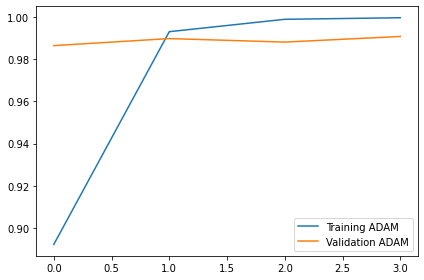

In [26]:
import matplotlib.pyplot as plt
model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

fig ,ax = plt.subplots(1 , figsize = (6,4))
num_epochs = model_history.shape[0]
ax.plot(np.arange(0 , num_epochs) , model_history['accuracy'] , label ='Training ADAM')
ax.plot(np.arange(0 , num_epochs) , model_history['val_accuracy'] , label = 'Validation ADAM')
ax.legend()

plt.tight_layout()
plt.show()

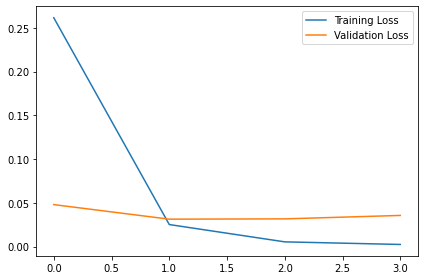

In [27]:
fig , ax = plt.subplots(1 ,figsize = (6,4))
num_epochs = model_history.shape[0]
ax.plot(np.arange(0 ,num_epochs ) , model_history['loss'] , label = 'Training Loss')
ax.plot(np.arange(0 , num_epochs) , model_history['val_loss'], label='Validation Loss')
ax.legend()
plt.tight_layout()
plt.show()

In [28]:
acc = model.evaluate(X_test,y_test)
print("Test set \n loss: {:0.3f}\n Accuracy: {:0.3f}".format(acc[0],acc[1]))

94/94 [==============================] - 6s 68ms/step - loss: 0.0313 - accuracy: 0.9897
Test set 
 loss: 0.031
 Accuracy: 0.990


In [29]:
input_test = ["Liverpool roll over Villarreal to put one foot in Champions League final"]

seq = tokenizer.texts_to_sequences(input_test)
padded = pad_sequences(seq , maxlen= max_len)
pred = model.predict(padded)
labels = ["Art" , "Economy" , "Sports"]

print(pred , labels[np.argmax(pred)])

[[1.5497301e-04 2.6242809e-05 9.9981886e-01]] Sports
